# Titanic rnd forest

In [23]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression, SGDClassifier, LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, cross_val_score, cross_val_predict ,GridSearchCV
from sklearn.model_selection import validation_curve, learning_curve
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import precision_score, recall_score, roc_curve, roc_auc_score

sns.set()

# This checks if the notebook is executed on Kaggle or on your local machine and
# acts accordingly with filenames.
fname_train = "train.csv"
fname_test = "test.csv"

try:
    os.environ['KAGGLE_DATA_PROXY_TOKEN']
except KeyError:
    pass
else:
    dirname = "/kaggle/input/titanic/"
    fname_train = dirname + fname_train
    fname_test = dirname + fname_test

In [24]:
titanic = pd.read_csv(fname_train)
titanic_orig = titanic


In [25]:
DROP_COLS = ["PassengerId", "Cabin", "SibSp", "Parch",
             "Ticket", "Name", "Fare", "Age", "Ticket_group_size", "Fare_p_person"]

In [47]:
titanic.loc[61, "Embarked"] = "S"
titanic.loc[829, "Embarked"] = "S"

class CabinLetterOnly(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y = None):
        return self
    def transform(self, X):
        df = pd.DataFrame(X, index=titanic_orig.index, columns=titanic_orig.columns)
        s_cabin_letters = df.Cabin.str.extract("^([A-Z]).*", expand = False)
        return np.c_[df.to_numpy(), s_cabin_letters]

cabin_letter_pip = Pipeline([
    ("cabin_letter_pip", CabinLetterOnly())
])

titanic = pd.DataFrame(cabin_letter_pip.fit_transform(titanic_orig), index=titanic_orig.index,
                       columns = titanic_orig.columns.union(pd.Index(["Cabin_letter"]), sort=False))


titanic.loc[ (titanic.Pclass == 1) & titanic.Cabin_letter.isna(), "Cabin_letter"] = 'C'
titanic.loc[ (titanic.Pclass == 2) & titanic.Cabin_letter.isna(), "Cabin_letter"] = 'F'
titanic.loc[ (titanic.Pclass == 3) & titanic.Cabin_letter.isna(), "Cabin_letter"] = 'G'

titanic["Family_size"] = titanic_orig.SibSp + titanic_orig.Parch

s_ticket_group = titanic.groupby("Ticket").size().rename("Ticket_group_size")
titanic = titanic.join(s_ticket_group, on="Ticket", sort=False)

titanic["Fare_p_person"] = pd.Series(np.nan)
titanic.loc[titanic.Ticket_group_size == 1, "Fare_p_person"] = titanic.loc[titanic.Ticket_group_size == 1, "Fare"]
titanic.loc[(titanic.Ticket_group_size > 1), "Fare_p_person"] = \
titanic.loc[(titanic.Ticket_group_size > 1), "Fare"] / (titanic.loc[(titanic.Ticket_group_size > 0), "Ticket_group_size"])

age_round = titanic_orig.Age.dropna().apply(np.floor)
titanic = titanic.join(age_round, lsuffix="_x", sort=False)
titanic.drop("Age_x", axis=1, inplace=True)


knnimputer = KNNImputer(n_neighbors=5, missing_values=np.nan)

mask = titanic.Age.notna() & ( (titanic.Fare_p_person < 12) | (titanic.Age < 12) )
df_children_or_low_fare = titanic.loc[mask, ["Family_size", "Fare_p_person", "Age"]]
knnimputer.fit(df_children_or_low_fare)
missing_age_low_fare = titanic.loc[(titanic.Fare_p_person < 12) & titanic.Age.isna()][["Family_size", "Fare_p_person", "Age"]]
imp = knnimputer.transform(missing_age_low_fare)
titanic.loc[(titanic.Fare_p_person < 12) & titanic.Age.isna(), "Age"] = imp[:, 2]

mask = titanic.Age.notna() & (titanic.Fare_p_person >= 12)
df_children_or_low_fare = titanic.loc[mask, ["Family_size", "Fare_p_person", "Age"]]
knnimputer.fit(df_children_or_low_fare)
missing_age_usual_fare = titanic.loc[(titanic.Fare_p_person >= 12) & titanic.Age.isna()][["Family_size", "Fare_p_person", "Age"]]
imp = knnimputer.transform(missing_age_usual_fare)
titanic.loc[(titanic.Fare_p_person >= 12) & titanic.Age.isna(), "Age"] = imp[:, 2]

titanic["Fare_cat"] = pd.cut(titanic.Fare_p_person, bins = [0, 13, 30, 513], include_lowest=True)

titanic["Age_cat"] = pd.cut(titanic["Age"].astype(int), bins = [-1, 20, 40, 60, 90])


sex_pip = Pipeline([
    ('one_hot', OneHotEncoder(categories=[titanic.Sex]))
    #('label', LabelEncoder())
])

fare_cat_pip = Pipeline([
    ('fare_std', OneHotEncoder(categories=[titanic.Fare_cat]))
])

pclass_pip = Pipeline([
    ('pclass_std', StandardScaler())
])

age_cat_pip = Pipeline([
    ('age_cat_std', OneHotEncoder(categories=[titanic.Age_cat]))
])

fsize_pip = Pipeline([
    ('fsize_std', StandardScaler())
])

cabin_pip = Pipeline([
    ('cabin_1hot', OneHotEncoder(categories=[titanic.Cabin_letter]))
])

embarked_pip = Pipeline([
    ('one_hot', OneHotEncoder(categories=[titanic.Embarked]))
])

attr_pip = ColumnTransformer([
    ("pclass", pclass_pip, ["Pclass"]),
    ("sex", sex_pip, ["Sex"]),
    ("fare_cat", fare_cat_pip, ["Fare_cat"]),
    ("age_cat", age_cat_pip, ["Age_cat"]),
    ("fsize", fsize_pip, ["Family_size"]),
    ("cabin", cabin_pip, ["Cabin_letter"]),
    ("embarked", embarked_pip, ["Embarked"])
], remainder="passthrough")

In [27]:
titanic.drop(DROP_COLS, axis=1, inplace=True)
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_ix, test_ix in split.split(titanic, titanic["Survived"]):
    strat_train = titanic.loc[train_ix]
    strat_devtest = titanic.loc[test_ix]

In [28]:
titanic_labels = titanic["Survived"].astype(int)
strat_train_labels = strat_train["Survived"].astype(int)
strat_devtest_labels = strat_devtest["Survived"].astype(int)
strat_train.drop(["Survived"], inplace=True, axis=1)
strat_devtest.drop(["Survived"], inplace=True, axis=1)

In [29]:
strat_train

,Pclass,Sex,Embarked,Cabin_letter,Family_size,Fare_cat,Age_cat
86,3,male,S,G,4,"(-0.001, 13.0]","(-1, 20]"
329,1,female,C,B,1,"(13.0, 30.0]","(-1, 20]"
517,3,male,Q,G,0,"(-0.001, 13.0]","(20, 40]"
844,3,male,S,G,0,"(-0.001, 13.0]","(-1, 20]"
408,3,male,S,G,0,"(-0.001, 13.0]","(20, 40]"
...,...,...,...,...,...,...,...
141,3,female,S,G,0,"(-0.001, 13.0]","(20, 40]"
736,3,female,S,G,4,"(-0.001, 13.0]","(40, 60]"
462,1,male,S,E,0,"(30.0, 513.0]","(40, 60]"
526,2,female,S,F,0,"(-0.001, 13.0]","(40, 60]"


In [30]:
strat_train_prep = attr_pip.fit_transform(strat_train)
strat_devtest_prep = attr_pip.fit_transform(strat_devtest)
skfold = StratifiedKFold(n_splits=5)

In [31]:
rnd_forest = RandomForestClassifier(random_state=42)
# don't know if skfold actually makes sense here
cross_val_score(rnd_forest, strat_train_prep, strat_train_labels, cv = skfold, scoring="accuracy")

array([0.79503106, 0.86875   , 0.74375   , 0.7875    , 0.79375   ])

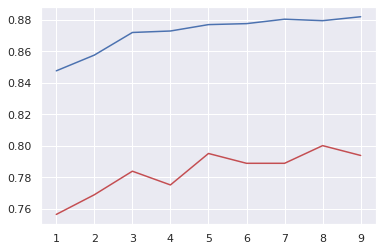

In [32]:
n_estimators_range = np.arange(1,10)
train_scores, test_scores = validation_curve(rnd_forest, strat_train_prep, strat_train_labels, param_name="n_estimators", param_range=n_estimators_range, scoring="accuracy", cv = skfold)
plt.plot(n_estimators_range, np.mean(train_scores, 1), label="train score", c='b')
plt.plot(n_estimators_range, np.mean(test_scores, 1), label="test score", c='r')

In [33]:
svd_rndforest_pip = Pipeline([
    ("svd", TruncatedSVD()),
    ("rnd_forest", RandomForestClassifier(n_jobs=-1))
])

param_grid = [
    {"svd__n_components" : [4,5], "rnd_forest__random_state" : [42], "rnd_forest__max_features" : [3,4,5],
     "rnd_forest__max_depth" : [3,4,5], "rnd_forest__n_estimators" : [100],
    "rnd_forest__min_samples_split" : [2,3,4], "rnd_forest__min_samples_leaf" : [2,3,4]}
]

param_grid = [
    {"random_state" : [42], "max_features" : [3,4,7], "max_depth" : [2,3,4], "n_estimators" : [100],
    "min_samples_split" : [2,3,4], "min_samples_leaf" : [2,3,4]}
]

gridsearch = GridSearchCV(rnd_forest, param_grid = param_grid, cv = skfold, scoring="accuracy", return_train_score=False)
#gridsearch = GridSearchCV(svd_rndforest_pip, param_grid = param_grid, cv = skfold, scoring="accuracy", return_train_score=False)
gridsearch.fit(strat_train_prep, strat_train_labels)
best_rnd_forest = gridsearch.best_estimator_

In [34]:
best_rnd_forest

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features=7,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

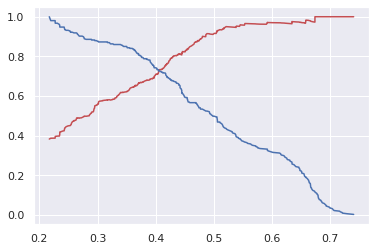

In [35]:
pred_scores = cross_val_predict(best_rnd_forest, strat_train_prep, strat_train_labels, cv = skfold, method="predict_proba")
precisions, recalls, thresholds = precision_recall_curve(strat_train_labels, pred_scores[:, 1])

sns.lineplot(thresholds, precisions[:-1], color="r")
sns.lineplot(thresholds, recalls[:-1], color="b")

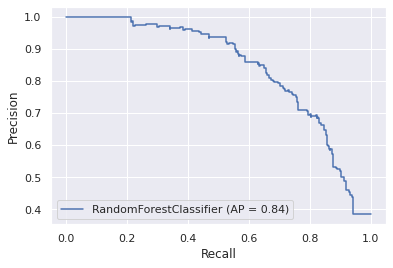

In [36]:
plot_precision_recall_curve(best_rnd_forest, strat_train_prep, strat_train_labels, response_method="predict_proba")

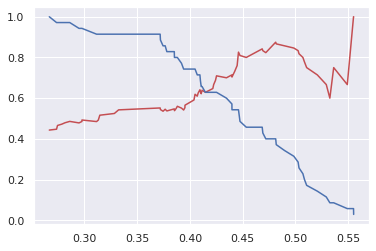

In [37]:
pred_scores = cross_val_predict(best_rnd_forest, strat_devtest_prep, strat_devtest_labels, cv = skfold, method="predict_proba")
precisions, recalls, thresholds = precision_recall_curve(strat_devtest_labels, pred_scores[:, 1])

sns.lineplot(thresholds, precisions[:-1], color="r")
sns.lineplot(thresholds, recalls[:-1], color="b")

In [38]:
pred = best_rnd_forest.predict(strat_devtest_prep)
confusion_matrix(strat_devtest_labels, pred)

array([[54,  1],
       [23, 12]])

In [39]:
rnd_forest.fit(strat_train_prep, strat_train_labels)
pred = rnd_forest.predict(strat_devtest_prep)
confusion_matrix(strat_devtest_labels, pred)

array([[46,  9],
       [13, 22]])

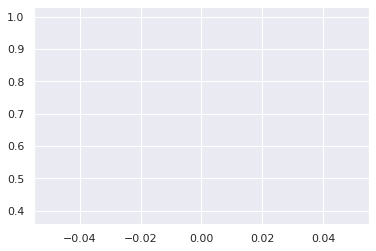

In [40]:
thresh = 0.65
custom_thresh_preds = pred_scores > thresh
precisions, recalls, thresholds = precision_recall_curve(strat_devtest_labels, custom_thresh_preds[:, 1])

sns.lineplot(thresholds, precisions[:-1], color="r")
sns.lineplot(thresholds, recalls[:-1], color="b")

In [41]:
confusion_matrix(strat_devtest_labels, custom_thresh_preds[:,1])

array([[55,  0],
       [35,  0]])

In [42]:
#best_model = RandomForestClassifier(random_state=42)
best_model = best_rnd_forest

full_train = titanic.drop("Survived", axis=1)
full_train_prep = attr_pip.fit_transform(full_train)
best_model.fit(full_train_prep, titanic_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features=7,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [49]:
test = pd.read_csv(fname_test)
test_orig = test

class CabinLetterTest(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y = None):
        return self
    def transform(self, X):
        df = pd.DataFrame(X, index=test.index, columns=test.columns)
        s_cabin_letters = df.Cabin.str.extract("^([A-Z]).*", expand = False)
        return np.c_[df.to_numpy(), s_cabin_letters]


cabin_letter_pip = Pipeline([
    ("cabin_letter_pip", CabinLetterTest())
])

test = pd.DataFrame(cabin_letter_pip.fit_transform(test), index=test.index,
                       columns = test.columns.union(pd.Index(["Cabin_letter"]), sort=False))
test.loc[ (test.Pclass == 1) & test.Cabin_letter.isna(), "Cabin_letter"] = 'C'
test.loc[ (test.Pclass == 2) & test.Cabin_letter.isna(), "Cabin_letter"] = 'F'
test.loc[ (test.Pclass == 3) & test.Cabin_letter.isna(), "Cabin_letter"] = 'G'

test["Family_size"] = test.SibSp + test.Parch

s_ticket_group = test.groupby("Ticket").size().rename("Ticket_group_size")
test = test.join(s_ticket_group, on="Ticket", sort=False)

test["Fare_p_person"] = pd.Series(np.nan)
test.loc[test.Ticket_group_size == 1, "Fare_p_person"] = test.loc[test.Ticket_group_size == 1, "Fare"]
test.loc[(test.Ticket_group_size > 1), "Fare_p_person"] = \
    test.loc[(test.Ticket_group_size > 1), "Fare"] / (test.loc[(test.Ticket_group_size > 0), "Ticket_group_size"])

test.loc[152, "Fare_p_person"] = 12.0

age_round = test.Age.dropna().apply(np.floor)
test = test.join(age_round, lsuffix="_x", sort=False)
test.drop("Age_x", axis=1, inplace=True)

knnimputer = KNNImputer(n_neighbors=5, missing_values=np.nan)

mask = test.Age.notna() & ( (test.Fare_p_person < 12) | (test.Age < 12) )
df_children_or_low_fare = test.loc[mask, ["Family_size", "Fare_p_person", "Age"]]
knnimputer.fit(df_children_or_low_fare)
missing_age_low_fare = test.loc[(test.Fare_p_person < 12) & test.Age.isna()][["Family_size", "Fare_p_person", "Age"]]
imp = knnimputer.transform(missing_age_low_fare)
test.loc[(test.Fare_p_person < 12) & test.Age.isna(), "Age"] = imp[:, 2]

mask = test.Age.notna() & (test.Fare_p_person >= 12)
df_children_or_low_fare = test.loc[mask, ["Family_size", "Fare_p_person", "Age"]]
knnimputer.fit(df_children_or_low_fare)
missing_age_usual_fare = test.loc[(test.Fare_p_person >= 12) & test.Age.isna()][["Family_size", "Fare_p_person", "Age"]]
imp = knnimputer.transform(missing_age_usual_fare)
test.loc[(test.Fare_p_person >= 12) & test.Age.isna(), "Age"] = imp[:, 2]

test["Fare_cat"] = pd.cut(test.Fare_p_person, bins = [0, 13, 30, 513], include_lowest=True)

test["Age_cat"] = pd.cut(test["Age"].astype(int), bins = [-1, 20, 40, 60, 90])

test.drop(DROP_COLS, inplace=True, axis=1)


In [50]:
test_prep = attr_pip.fit_transform(test)
test_prep

<418x4457 sparse matrix of type '<class 'numpy.float64'>'
	with 2926 stored elements in Compressed Sparse Row format>

In [59]:
onehot = OneHotEncoder(categories=[titanic.Fare_cat], )
onehot.fit_transform(pd.DataFrame({"Fare_cat":titanic.Fare_cat}))
onehot.categories

[0      (-0.001, 13.0]
 1       (30.0, 513.0]
 2      (-0.001, 13.0]
 3        (13.0, 30.0]
 4      (-0.001, 13.0]
             ...      
 886    (-0.001, 13.0]
 887      (13.0, 30.0]
 888    (-0.001, 13.0]
 889      (13.0, 30.0]
 890    (-0.001, 13.0]
 Name: Fare_cat, Length: 891, dtype: category
 Categories (3, interval[float64]): [(-0.001, 13.0] < (13.0, 30.0] < (30.0, 513.0]]]

In [51]:
# sex_pip = Pipeline([
#     ('one_hot', OneHotEncoder(categories=[test.Sex]))
#     #('label', LabelEncoder())
# ])

# fare_cat_pip = Pipeline([
#     ('fare_std', OneHotEncoder(categories=[test.Fare_cat]))
# ])

# age_cat_pip = Pipeline([
#     ('age_cat_std', OneHotEncoder(categories=[test.Age_cat]))
# ])

# cabin_pip = Pipeline([
#     ('cabin_1hot', OneHotEncoder(categories=[titanic.Cabin_letter]))
# ])

# embarked_pip = Pipeline([
#     ('one_hot', OneHotEncoder(categories=[titanic.Embarked]))
# ])

# attr_pip = ColumnTransformer([
#     ("pclass", pclass_pip, ["Pclass"]),
#     ("sex", sex_pip, ["Sex"]),
#     ("fare_cat", fare_cat_pip, ["Fare_cat"]),
#     ("age_cat", age_cat_pip, ["Age_cat"]),
#     ("fsize", fsize_pip, ["Family_size"]),
#     ("cabin", cabin_pip, ["Cabin_letter"]),
#     ("embarked", embarked_pip, ["Embarked"])
# ], remainder="passthrough")

test_prep = attr_pip.fit_transform(test)

#titanic_prep = attr_pip.fit_transform(titanic)

#sgd_clf.fit(titanic_prep, titanic_labels)
#survival_pred = sgd_clf.predict(test_prep)

survival_pred = best_model.predict(test_prep)


# survival_proba = best_model.predict_proba(test_prep)
# survival_pred = survival_proba > thresh
# survival_pred = survival_pred[:, 1].astype(int)


survival_pred = pd.DataFrame(survival_pred, columns=["Survived"])

id_survival = pd.concat([test_orig.PassengerId, survival_pred], axis=1)
id_survival.set_index("PassengerId", inplace=True)
id_survival.to_csv("predicition.csv")
id_survival

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,0
...,...
1305,0
1306,1
1307,0
